# Chart individual seat probabilities

## Python set-up

In [1]:
import re
from typing import Callable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from IPython.display import display
import plotting

In [2]:
%load_ext watermark
%watermark --machine --python --iversions --conda

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.1.0

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

IPython   : 9.1.0
numpy     : 2.2.4
matplotlib: 3.10.1
pandas    : 2.2.3
seaborn   : 0.13.2
re        : 2.2.1



In [3]:
## Plotting initialisation
def set_up_plotting() -> None:
    """Set up plotting."""

    p = plotting.get_chart_dir()
    plotting.set_chart_dir(p + "/individual-seats/")
    plotting.clear_chart_dir()


set_up_plotting()
SHOW = False

## Get data

In [4]:
FILE = "../betting-data/sportsbet-2025-electorate-betting.csv"
REMOVE_BRACKETS = r"\s*\(.*?\)"

In [5]:
betting_df = pd.read_csv(
    FILE, na_values=["SUS", "Suspended"], parse_dates=["timestamp"]
)


def diagnostics(df: pd.DataFrame) -> None:
    """Print diagnostics for the dataframe."""
    print(f"data shape: {df.shape}")
    print(f"data length: {len(df)}")
    print(f"data start: {df['timestamp'].min()}")
    print(f"data end: {df['timestamp'].max()}")
    print(f"data columns: {df.columns}")
    last = df["timestamp"].max()
    last_count = len(df[df["timestamp"] == last].seat.unique())
    print(
        f"Latest seat count: {last_count} rows)",
    )
    if last_count < 150:
        missing = set(df.seat) - set(df[df["timestamp"] == last].seat)
        print(f"Missing seats for most recent collection: {missing}")
    print(
        "Party groups:",
        betting_df.party.str.replace(REMOVE_BRACKETS, "", regex=True).unique(),
    )


diagnostics(betting_df)

data shape: (10021, 5)
data length: 10021
data start: 2025-03-30 23:21:13.467650
data end: 2025-04-18 07:01:07.456075
data columns: Index(['Unnamed: 0', 'seat', 'party', 'price', 'timestamp'], dtype='object')
Latest seat count: 149 rows)
Missing seats for most recent collection: {'Franklin (TAS)'}
Party groups: ['Labor' 'Coalition' 'Greens' 'Any Other Candidate' 'Independent'
 'One Nation' "Katter's Australian Party" 'Centre Alliance']


In [6]:
# A useful presentation for checking the raw data
DO_THIS = False
if DO_THIS:
    display(
        betting_df.pivot(columns="timestamp", index=["seat", "party"], values="price")
        .T.tail(2)
        .T
    )

## Plot distribution of simple overrounds

In [7]:
def calculate_overrounds(
    df: pd.DataFrame,
    seat: str,
) -> pd.Series:
    """Calculate the bookmaker's overround for a given seat."""

    seat_data = df[df["seat"] == seat]
    seat_overrounds = (
        seat_data.dropna(subset=["price"])  # Remove rows with no price
        .pivot(index="timestamp", columns="party", values="price")
        .pipe(lambda x: 1 / x)
        .sum(axis=1)
    )

    return seat_overrounds

In [8]:
def capture_latest_overrounds(
    df: pd.DataFrame,
    min_threshold: float = 1.05,
) -> pd.Series:
    """Capture the latest overrounds for each seat in the dataframe.
    The overround is calculated as the sum of the inverse of the
    prices for each party.
    Report any seats with an overround less than the minimum threshold
    for the latest data collection.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    min_threshold: float - The minimum expected bookmaker's overround."""

    # Filter out rows with missing prices
    df = df.dropna(subset=["price"])

    # Calculate the overround for each seat
    overrounds = {}
    for seat in df.seat.unique():
        overrounds[seat] = (
            calculate_overrounds(df, seat).dropna(how="all", axis=0).iloc[-1]
        )
    series = pd.Series(overrounds)

    # Report any seats with an overround less than the minimum threshold
    too_low = series[series <= min_threshold]
    if len(too_low):
        print("We have some low overrounds in the latest collection:")
        for seat in too_low.index:
            print(
                seat,
            )
            print(
                df[df.seat == seat]
                .pivot(index="timestamp", columns="party", values="price")
                .iloc[-1]
            )
        print("-" * 30)

    return series

We have some low overrounds in the latest collection:
Bendigo (VIC)
party
Any Other Candidate    26.00
Coalition                NaN
Labor                   1.03
Name: 2025-04-18 07:01:07.456075, dtype: float64
Lyons (TAS)
party
Any Other Candidate    26.0
Coalition               1.7
Labor                   NaN
Name: 2025-04-18 07:01:07.456075, dtype: float64
------------------------------


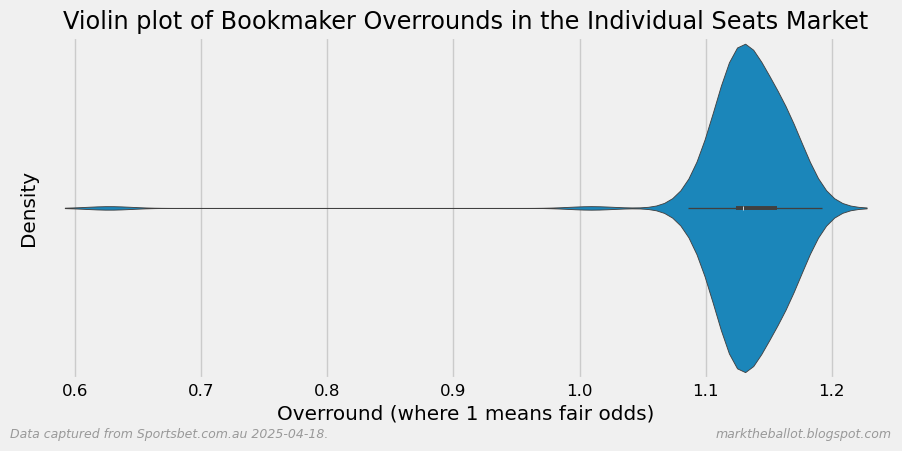

In [9]:
def plot_overrounds() -> None:
    """
    Plot the latest overrounds for each seat in the dataframe.
    """
    overround_series = capture_latest_overrounds(betting_df)
    ax = sns.violinplot(x=overround_series, orient="h")
    title = "Violin plot of Bookmaker Overrounds in the Individual Seats Market"
    plotting.finalise_plot(
        ax,
        title=title,
        ylabel="Density",
        xlabel="Overround (where 1 means fair odds)",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{betting_df["timestamp"].max().date()}. ',
        show=True,
    )


plot_overrounds()

## Summarise likely result and identify seats of interest

In [10]:
def calc_probability(
    df: pd.DataFrame,  # DataFrame containing betting data
    seat: str,  # The seat to calculate probabilities for
    # Favourite-Longshot Bias management:
    exclude_above: float = 25.0,  # exclude any odds above this value
    lsb_cap: float = 7.5,  # only inflate odds if they are > lsb_cap
    lsb_method: Callable | None = lambda x: x * np.sqrt(x),  # odds inflation method
    method_text: str = "raw-odds * sqrt(raw-odds)",
) -> tuple[pd.DataFrame, str, pd.Index] | None:
    """Calculate the probability of winning for each party in a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to calculate probabilities for.
    exclude_above: float - Exclude any odds above this value.
    lsb_cap: float - Only inflate odds if they are > lsb_cap.
    lsb_method: Callable | None - The method to use for inflating odds.
    Returns a tuple comprising:
    1. A DataFrame of seat probabilities
    2. A string explaining how the favourite-longshot bias was treated, and
    3. An index of dates with interpolated probabilities for missing odds."""

    # assume bookmaker's overround is at least 5%
    minimum_overround = 1.05

    # get the data for the seat
    seat_df = df[df.seat == seat]
    if seat_df.empty:
        print(f"No data for seat {seat}")
        return None

    # identify and replace missing odds, based on overround
    overs = calculate_overrounds(seat_df, seat)

    pivot = seat_df.pivot(index="timestamp", columns="party", values="price")
    pivot2 = pivot.where(overs >= minimum_overround, other=pivot.ffill())
    adjusted = (pivot.fillna(0) != pivot2.fillna(0)).sum(axis=1)
    adjusted_index = adjusted[adjusted > 0].index

    # remove any odds above the exclude_above threshold
    pivot2[pivot2 > exclude_above] = np.nan
    pivot2 = pivot2.dropna(axis=1, how="all")

    # get seat probabilities - treat for favourite-longshot bias
    seat_prob = (
        pivot2.pipe(  # type: ignore[call-overload]
            (
                lambda x: (
                    x
                    if lsb_method is None
                    else x.where(
                        x <= lsb_cap, other=lsb_method(x)  # type: ignore[arg-type, misc]
                    )
                )
            )
        )
        .pipe(lambda x: 1 / x)  # convert from odds to probability
        .pipe(lambda x: x.div(other=x.sum(axis=1), axis=0))  # normalise probabilities
    ) * 100  # per cent

    explainer = ""
    explanations = []
    if exclude_above > 0:
        explanations.append(f"Odds excluded above \\${exclude_above}")
    if lsb_method is not None:
        odds_cap = f", where odds > \\${lsb_cap}" if lsb_cap else ""
        explanations.append(f"{method_text}{odds_cap}")
    if explanations:
        explainer = "Favourite-Longshot Bias treatment: " + "; ".join(explanations)

    return seat_prob, explainer, adjusted_index

In [11]:
def colourise(s: str, count: int = 0) -> tuple[str, str]:
    """A standard color and marker scheme for parties."""

    settings = {
        "coalition": ("royalblue", "s"),
        "labor": ("#dd0000", "d"),
        "green": ("mediumseagreen", "o"),
        "independent": (
            ["darkorange", "orange", "purple", "teal"][count],
            "v>^<"[count],
        ),
        "one nation": ("darkkhaki", "H"),
        "jacqui lambie": ("darkorchid", "P"),
        "katter": ("hotpink", "X"),
        "centre alliance": ("brown", "P"),
        "other": ("skyblue", "|"),  # must be last
    }
    for party, setting in settings.items():
        if party in s.lower():
            return setting

    return ("gray", "*")


class Coloriser:
    """A class to handle colorisation of party names.
    Note: this is a bit of a hack, but it works for now.
    It allows for multiple independents to be colourised differently."""

    def __init__(self):
        self.x = {}

    def __call__(self, s: str) -> tuple[str, str]:
        core = re.sub(REMOVE_BRACKETS, "", s).strip()
        count = self.x.get(core, -1) + 1
        self.x[core] = count
        return colourise(s, count)


_color = Coloriser()
print(_color("Independent"))
print(_color("Independent"))

('darkorange', 'v')
('orange', '>')


Grouped probabilities for Calare (NSW): Index(['Coalition', 'Independent (Andrew Gee)', 'Independent (Kate Hook)'], dtype='object', name='party')
Grouped probabilities for Monash (VIC): Index(['Any Other Candidate', 'Coalition', 'Independent (Deb Leonard)',
       'Independent (Russell Broadbent)'],
      dtype='object', name='party')
Close seats:


,index,Top probability %,ahead
3,Brisbane (QLD),40.4,Labor
28,Ryan (QLD),46.7,Coalition
20,Macnamara (VIC),47.0,Labor
25,Paterson (NSW),49.5,Labor
2,Bradfield (NSW),50.0,"Coalition=, Independent (Nicolette Boele)"
0,Bennelong (NSW),51.0,Coalition
4,Bullwinkel (WA),51.0,Labor
6,Chisholm (VIC),51.0,Labor
7,Cowper (NSW),51.0,Independent (Caz Heise)
8,Curtin (WA),51.0,Independent (Kate Chaney)


Seats where Greens might be competitive:


,Greens win probability %
Melbourne (VIC),87.7
Griffith (QLD),57.1
Wills (VIC),42.7
Macnamara (VIC),37.4
Brisbane (QLD),35.0
Ryan (QLD),32.2
Richmond (NSW),29.1


Seats where Others might be competitive:


,Others win probability %
Clark (TAS),100.0
Kennedy (QLD),96.3
Warringah (NSW),86.8
Indi (VIC),80.3
Mayo (SA),79.9
Wentworth (NSW),78.4
Mackellar (NSW),69.4
Fowler (NSW),66.4
Goldstein (VIC),56.3
Curtin (WA),51.0


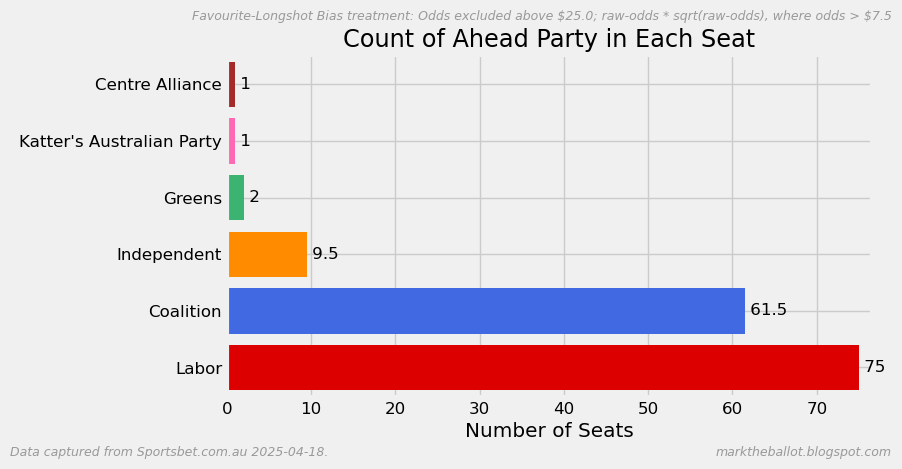

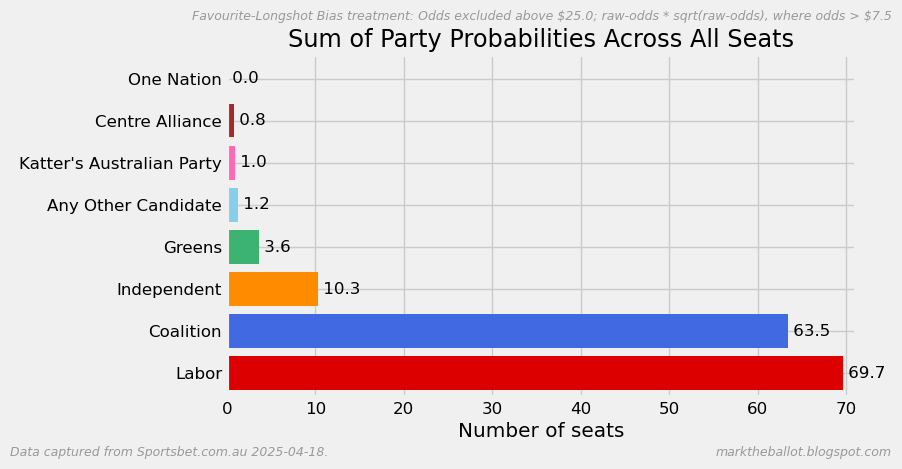

In [12]:
def plot_ahead_count(party_count: dict[str, float], method: str) -> None:
    """Plot the count of the ahead party in each seat."""

    winners = pd.Series(party_count).sort_values(ascending=False)
    assert (
        winners.sum() == 150
    ), f"Count of ahead parties does not sum to 150 {winners.sum()}"
    colors = [colourise(x)[0] for x in winners.index]
    _fig, ax = plt.subplots()
    ax.barh(winners.index, winners, color=colors)
    for i, v in enumerate(winners):
        rounded: str = f"{v:.1f}".rstrip("0").rstrip(".")
        ax.text(v, i, f" {rounded}", color="black", va="center", ha="left")  # type: ignore[arg-type]
    plotting.finalise_plot(
        ax,
        title="Count of Ahead Party in Each Seat",
        ylabel=None,
        xlabel="Number of Seats",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{betting_df["timestamp"].max().date()}. ',
        rheader=method,
        show=True,
    )


def plot_party_prob_sum(all_seats_probs: dict[str, pd.Series], method: str) -> None:
    """Plot the party-probability sums."""

    party_probs = pd.DataFrame(all_seats_probs).T.sum().sort_values(ascending=False)
    assert (
        149.9 < party_probs.sum() < 150.1
    ), f"Probabilities do not sum to 150 seats {party_probs.sum()}"
    colors = [colourise(x)[0] for x in party_probs.index]
    _fig, ax = plt.subplots()
    ax.barh(party_probs.index, party_probs, color=colors)
    for i, v in enumerate(party_probs):
        ax.text(v, i, f" {v:0.1f}", color="black", va="center", ha="left")
    plotting.finalise_plot(
        ax,
        title="Sum of Party Probabilities Across All Seats",
        ylabel=None,
        xlabel="Number of seats",
        rfooter="marktheballot.blogspot.com",
        lfooter="Data captured from Sportsbet.com.au "
        + f'{betting_df["timestamp"].max().date()}. ',
        rheader=method,
        show=True,
    )


def tables_of_interest(
    all_seats_probs: dict[str, pd.Series], individual_leaders: dict[str, str]
) -> None:
    """Create tables of interest from the betting data."""

    # tavulate close seats
    seat_probs = pd.DataFrame(all_seats_probs).T * 100
    close_threshold = 70
    close_seats = seat_probs[seat_probs.max(axis=1) <= close_threshold]
    maxima = close_seats.max(axis=1).round(1)
    ahead = pd.Series(individual_leaders)[maxima.index]
    results = pd.DataFrame(
        {
            "Top probability %": maxima,
            "ahead": ahead,
        }
    )
    results = results.reset_index().sort_values(by="Top probability %", ascending=True)
    print("Close seats:")
    display(results)

    # Green possible seats
    green_threshold = 20
    greens = seat_probs["Greens"]
    green_competitive = (
        greens[greens >= green_threshold].sort_values(ascending=False).round(1)
    )
    print("Seats where Greens might be competitive:")
    frame = pd.DataFrame(green_competitive)
    frame.columns = pd.Index(["Greens win probability %"])
    display(frame)

    # Others possible
    other_threshold = 20
    others = seat_probs.drop(columns=["Greens", "Labor", "Coalition"]).sum(axis=1)
    other_competitive = others[others >= other_threshold].sort_values(ascending=False)
    print("Seats where Others might be competitive:")
    display(
        pd.DataFrame(other_competitive, columns=["Others win probability %"]).round(1)
    )


def plot_stacked_probs(all_seats_probs: dict[str, pd.Series], method: str) -> None:
    """Plot the stacked probabilities for each party."""

    # Create a DataFrame from the dictionary
    seat_probs = (pd.DataFrame(all_seats_probs).T * 100).sort_values(
        by="Labor", ascending=False
    )

    first_columns = [f for f in ("Coalition", "One Nation") if f in seat_probs.columns]
    last_columns = [
        f for f in ("Any Other Candidate", "Greens", "Labor") if f in seat_probs.columns
    ]
    order = (
        first_columns
        + [x for x in seat_probs.columns if x not in first_columns + last_columns]
        + last_columns
    )
    seat_probs = seat_probs[order]
    colours = [colourise(x)[0] for x in seat_probs.columns]

    slices = [slice(0, 150), slice(0, 50), slice(50, 100), slice(100, 150)]
    for i, s in enumerate(slices):
        suffix = {0: "", 1: "(C)", 2: "(B)", 3: "(A)"}[i]
        size = {0: (9, 25), 1: (9, 9), 2: (9, 9), 3: (9, 9)}[i]
        lpos = {0: "lower right", 1: "lower right", 2: "lower right", 3: "center left"}[
            i
        ]

        ax = seat_probs.iloc[s].plot.barh(stacked=True, color=colours)  # type: ignore[arg-type]
        ax.axvline(50, color="black", linestyle="-", linewidth=0.75)
        ax.margins(0.002)
        plotting.finalise_plot(
            ax,
            title=f"Stacked Win Probabilities for Each Seat {suffix}".strip(),
            ylabel=None,
            xlabel="Win Probability %",
            rfooter="marktheballot.blogspot.com",
            lfooter="Data captured from Sportsbet.com.au "
            + f'{betting_df["timestamp"].max().date()}. ',
            rheader=method,
            show=False,
            legend={"loc": lpos, "fontsize": "x-small", "framealpha": 1.0},
            figsize=size,
        )


def summarise_seats_data() -> None:
    """Summarise the individual seat betting data."""

    all_seats_probs = {}  # {seat: series_of_probabilities}
    party_ahead_count: dict[str, float] = {}  # {party: count}
    individual_leaders = {}  # {seat: party}
    for seat in betting_df.seat.unique():
        # get latest seat probabilities
        p = calc_probability(betting_df, seat)
        if p is None:
            print(f"No data for seat {seat}")
            continue
        seat_probs, method, _dates_missing_odds = p
        latest = seat_probs.iloc[-1].dropna()

        # get and count the party/ies ahead - allow for fractional counts when tied
        maxima = latest.max()
        leaders = latest[latest == maxima].index.tolist()
        for leader in leaders:
            party = re.sub(REMOVE_BRACKETS, "", leader).strip()
            party_ahead_count[party] = party_ahead_count.get(party, 0) + (
                1 / len(leaders)
            )
        individual_leaders[seat] = "=, ".join(leaders)

        # let's group probabilities by party name (ignore candidate names)
        renamer = {x: re.sub(REMOVE_BRACKETS, "", x).strip() for x in latest.index}
        groups = latest.rename(index=renamer)
        groups_combined = groups.groupby(
            groups.index
        ).sum()  # eg. more than one independent candidate
        if len(groups_combined) < len(groups):
            print(f"Grouped probabilities for {seat}: {latest.index}")
        all_seats_probs[seat] = groups_combined / 100  # convert to simplex

    tables_of_interest(all_seats_probs, individual_leaders)

    plot_ahead_count(party_ahead_count, method)

    plot_party_prob_sum(all_seats_probs, method)

    plot_stacked_probs(all_seats_probs, method)


summarise_seats_data()

## Plot individual seats

In [13]:
CHANGES = []


def plot_seat_probs(df: pd.DataFrame, seat: str) -> None:
    """
    Plot the seat probabilities for a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to plot.
    """

    # get seat probabilities - treat for favourite-longshot bias
    p = calc_probability(df, seat)
    if p is None:
        print(f"No data for seat {seat}")
        return
    seat_probs, flb_method, dates_missing_odds = p

    # make the index a daily period index and de-duplicate.
    seat_probs.index = pd.PeriodIndex(seat_probs.index, freq="D")
    seat_probs = seat_probs[~seat_probs.index.duplicated(keep="last")]
    if len(seat_probs) > 2 and (seat_probs.iloc[-1] != seat_probs.iloc[-2]).any():
        CHANGES.append(seat)
    missing_periods = pd.PeriodIndex(dates_missing_odds, freq="D")

    # plot
    ax = None
    color = Coloriser()
    for column in seat_probs.columns:
        c, m = color(column)
        ax = seat_probs[column].plot(
            ax=ax,
            markersize=6,
            lw=2.5,
            color=c,
            marker=m,
        )
        if seat_probs[column].iloc[-1] >= 10:
            ax.text(
                seat_probs.index[-1],
                seat_probs[column].iloc[-1],
                f"  {seat_probs[column].iloc[-1]:.0f}",
                fontsize=9,
                color="#444444",
                ha="left",
                va="center",
            )
    if ax is None:
        print(f"No data for seat {seat}")
        return

    if missing_periods is not None and len(missing_periods) > 0:
        label = "Missing odds"
        for period in missing_periods:  # type: ignore[attr-defined]
            ax.axvspan(
                period.ordinal - 0.5,
                period.ordinal + 0.5,
                color="gray",
                alpha=0.20,
                label=label,
            )
            label = "_nolegend_"

    plotting.finalise_plot(
        ax,
        title=f"Sportsbet seat win probabilities over time - {seat}",
        ylabel="Implied Win Probability (%)",
        lfooter=flb_method,
        rheader="marktheballot.blogspot.com",
        legend={"loc": "best", "ncol": 2, "fontsize": "small"},
        ylim=(-5, 105),
        y50=True,
        pre_tag="yy",
        show=SHOW,
    )


def plot_seat_odds(df: pd.DataFrame, seat: str) -> None:
    """
    Plot the seat odds for a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to plot.
    """

    # get seat odds - without FLB treatment
    df = df[df.seat == seat]
    odds = df.pivot(index="timestamp", columns="party", values="price")
    odds.index = pd.PeriodIndex(odds.index, freq="D")
    odds = odds[~odds.index.duplicated(keep="last")]
    odds = odds.sort_index(ascending=True)

    ax = None
    color = Coloriser()
    for column in odds.columns:
        c, m = color(column)
        ax = odds[column].plot(
            ax=ax,
            markersize=6,
            lw=2.5,
            color=c,
            marker=m,
        )
        value = odds[column].iloc[-1]
        if odds[column].iloc[-1] <= 31:
            rounding = 2 if value >= 1.01 else 3
            ax.text(
                odds.index[-1],
                value,
                f"  \\${value:.{rounding}f}",
                fontsize=9,
                color="#444444",
                ha="left",
                va="center",
            )

    if ax is None:
        print(f"No data for seat {seat}")
        return

    use_log_scale = False
    if use_log_scale:
        ax.set_yscale("log")
    minmax = ax.get_ylim()
    minmax = (0.9 if use_log_scale else 0, minmax[1])

    plotting.finalise_plot(
        ax,
        title=f"Sportsbet seat odds over time - {seat}",
        ylabel="$ Odds" + (" on a log scale" if use_log_scale else ""),
        lfooter="Decimal odds from Sportsbet.com.au",
        rfooter="marktheballot.blogspot.com",
        legend={"loc": "best", "ncol": 2, "fontsize": "small"},
        pre_tag="zz",
        ylim=minmax,
        show=SHOW,
    )


def plot_all_seats():
    """Plot the seat probabilities for all seats."""

    for seat in betting_df.seat.unique():
        plot_seat_probs(betting_df, seat)
        plot_seat_odds(betting_df, seat)

    if CHANGES:
        print("Seats with changes from penultimate day:", CHANGES)


plot_all_seats()

Seats with changes from penultimate day: ['Bass (TAS)', 'Calare (NSW)', 'Cunningham (NSW)', 'Dickson (QLD)', 'Dobell (NSW)', 'Eden-Monaro (NSW)', 'Farrer (NSW)', 'Fisher (QLD)', 'Flinders (VIC)', 'Franklin (TAS)', 'Fremantle (WA)', 'Gilmore (NSW)', 'Grey (SA)', 'Groom (QLD)', 'Hawke (VIC)', 'Hindmarsh (SA)', 'Hunter (NSW)', 'Longman (QLD)', 'Lyons (TAS)', 'Macquarie (NSW)', 'Melbourne (VIC)', 'Monash (VIC)', 'Paterson (NSW)', 'Whitlam (NSW)']


## Finished

In [14]:
print("finished")

finished
